In [1]:
# 0. 라이브러리 설치
# %pip install tensorflow
# %pip install numpy
# %pip install pandas
# %pip install openpyxl

In [2]:
#%nvidia-smi

In [3]:
# 1. 라이브러리 임포트
# -*- coding: utf-8 -*-
"""
Original created on Tue May 1 15:31:04 2018
@author: zhaoyuzhi
Updated to modern TensorFlow API in 2025
"""

import tensorflow as tf
import numpy as np
import pandas as pd
import os
from PIL import Image
import openpyxl  # xlrd 대신 openpyxl 사용

# 로깅 레벨 설정
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'


2025-03-21 15:28:29.531441: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-21 15:28:29.758103: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-03-21 15:28:30.571587: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [4]:
%pwd

'/home/potato/박선영/CNN-Based-Data-Driven-Fault-Diagnosis'

In [5]:
# 2. 경로 설정
# 경로 설정 (필요에 따라 수정)
IMAGESAVEURL_training = "/home/potato/박선영/CNN-Based-Data-Driven-Fault-Diagnosis/generated_data(2000)/train_images"
IMAGESAVEURL_validation = "/home/potato/박선영/CNN-Based-Data-Driven-Fault-Diagnosis/generated_data(2000)/test_images"

In [6]:
# 3. Excel 파일 로드
# Excel 파일 로드 (xlrd 대신 openpyxl 사용)
training_wb = openpyxl.load_workbook('/home/potato/박선영/CNN-Based-Data-Driven-Fault-Diagnosis/generated_data(2000)/trainingImageList.xlsx')
training_sheet = training_wb.active
validation_wb = openpyxl.load_workbook('/home/potato/박선영/CNN-Based-Data-Driven-Fault-Diagnosis/generated_data(2000)/validationImageList.xlsx')
validation_sheet = validation_wb.active

In [7]:
# 4. 데이터 배열 초기화
# 데이터 저장용 배열 초기화
train_num=80000
test_num=16000
x_data = np.zeros([train_num, 64, 64], dtype=np.float32)
y_data = np.zeros([train_num, 10], dtype=np.float32)
x_test = np.zeros([test_num, 64, 64], dtype=np.float32)
y_test = np.zeros([test_num, 10], dtype=np.float32)

In [8]:
# 5. 학습 데이터 처리
# 학습 데이터 처리
for i in range(train_num):
    imagename = training_sheet.cell(i+1, 1).value  # 이미지 파일명
        # **파일명 검증 (None이면 스킵)**
    if imagename is None:
        print(f"⚠ 스킵된 행: {i+1}, 파일명: {imagename}")
        continue
    image = Image.open(os.path.join(IMAGESAVEURL_training, imagename))

    # 이미지 전처리 (그레이스케일 변환 및 정규화)
    imagedata = np.array(image.convert('L'), dtype='float32') / 255.0
    x_data[i, :, :] = imagedata

    # 10개 클래스에 맞춰 원-핫 벡터 생성
    label_index = int(training_sheet.cell(i+1, 2).value)  # 예: 0~9 사이의 값
    y_data[i, label_index] = 1  # 해당 위치만 1로 설정

In [9]:
# 6. 테스트 데이터 처리
# 테스트 데이터 처리
for i in range(test_num):
    # 이미지 불러오기
    imagename = validation_sheet.cell(i+1, 1).value
    image = Image.open(os.path.join(IMAGESAVEURL_validation, imagename))
    width, height = image.size
    # 이미지를 그레이스케일로 변환하고 정규화
    imagedata = np.array(image.convert('L'), dtype='float32') / 255.0
    # 데이터 저장
    x_test[i, :, :] = imagedata
    # 10개 클래스에 맞춰 원-핫 벡터 생성
    label_index = int(validation_sheet.cell(i+1, 2).value)  # 예: 0~9 사이의 값
    y_test[i, label_index] = 1  # 해당 위치만 1로 설정


In [10]:
# 7. CNN 모델 정의 함수
# 모델 정의
def create_cnn_model():
    # 함수형 API 사용
    inputs = tf.keras.Input(shape=(64, 64, 1))

    # 첫 번째 합성곱 레이어 및 풀링
    x = tf.keras.layers.Conv2D(32, (5, 5), padding='same', activation='relu')(inputs)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)

    # 두 번째 합성곱 레이어 및 풀링
    x = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)

    # 세 번째 합성곱 레이어 및 풀링
    x = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)

    # 네 번째 합성곱 레이어 및 풀링
    x = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)

    # 플래튼 레이어
    x = tf.keras.layers.Flatten()(x)

    # 완전 연결 레이어 1
    x = tf.keras.layers.Dense(2560, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.6)(x)  # keep_prob 0.4 -> dropout 0.6

    # 완전 연결 레이어 2 (출력 레이어)
    outputs = tf.keras.layers.Dense(10, activation='softmax')(x)

    # 모델 생성
    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    return model

In [11]:
# 8. 모델 생성 및 컴파일
# 모델 생성 및 컴파일
model = create_cnn_model()
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-6),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()

2025-03-21 15:28:53.885118: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-03-21 15:28:54.038997: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-03-21 15:28:54.039114: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-03-21 15:28:54.042865: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-03-21 15:28:54.042910: I external/local_xla/xla/stream_executor

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 64, 64, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 64, 64, 32)     │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2560)           │    10,488,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2560)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │        25,610 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,902,282 (41.59 MB)

 Trainable params: 10,902,282 (41.59 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# 9. 데이터셋 생성
# 학습용 데이터셋 생성
# TensorFlow 데이터셋 API 사용
batch_size = 16
train_dataset = tf.data.Dataset.from_tensor_slices((
    np.expand_dims(x_data, -1),  # 채널 차원 추가
    y_data
)).batch(batch_size)

# 테스트용 데이터셋 생성
test_dataset = tf.data.Dataset.from_tensor_slices((
    np.expand_dims(x_test, -1),  # 채널 차원 추가
    y_test
)).batch(batch_size)

: 

In [ ]:
# 10. 모델 학습
# 모델 학습
epochs = 12
for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")
    # 학습
    for step, (x_batch, y_batch) in enumerate(train_dataset):
        loss = model.train_on_batch(x_batch, y_batch)
        if step % 125 == 0:
            print(f'  Step {step}, Loss: {loss[0]}')

Epoch 1/12


I0000 00:00:1742538542.311680   27497 service.cc:145] XLA service 0x453a1a50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1742538542.311936   27497 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3050, Compute Capability 8.6
2025-03-21 15:29:02.383456: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-03-21 15:29:02.620171: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


In [ ]:
# 11. 모델 평가
# 테스트 데이터로 모델 평가
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"테스트 정확도: {test_accuracy:.4f}")

125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.0327 - loss: 2.2759
테스트 정확도: 0.1835


In [ ]:
# 12. 예측 결과 저장
# 예측 결과 저장
predictions = model.predict(test_dataset)
print(f"예측 형태: {predictions.shape}")

125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step
예측 형태: (2000, 10)


In [ ]:
# 13. 모델 저장
# 모델 저장
model.save('cnn_model.h5')
print("모델이 cnn_model.h5로 저장되었습니다.")

모델이 cnn_model.h5로 저장되었습니다.


In [ ]:
##############appendix###################

In [ ]:
#pip install matplotlib scikit-learn seaborn

In [ ]:
#%pip install matplotlib
#%pip install seaborn

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


In [ ]:
# 1. 실제 라벨 (one-hot encoded → label index 변환)
y_true = np.argmax(y_test, axis=1)  # 실제 라벨

# 2. 예측 결과 (확률값 → 가장 높은 확률의 클래스 선택)
y_pred = np.argmax(predictions, axis=1)  # 예측된 라벨


In [ ]:
from sklearn.metrics import confusion_matrix

# Confusion Matrix 계산
cm = confusion_matrix(y_true, y_pred)

# 퍼센트 값으로 변환 (0으로 나누는 문제 방지)
cm_sum = cm.sum(axis=1, keepdims=True)
cm_percentage = np.divide(cm.astype(float), cm_sum, where=(cm_sum != 0)) * 100  # 0으로 나누는 것 방지
cm_percentage = np.nan_to_num(cm_percentage)  # NaN을 0으로 변환


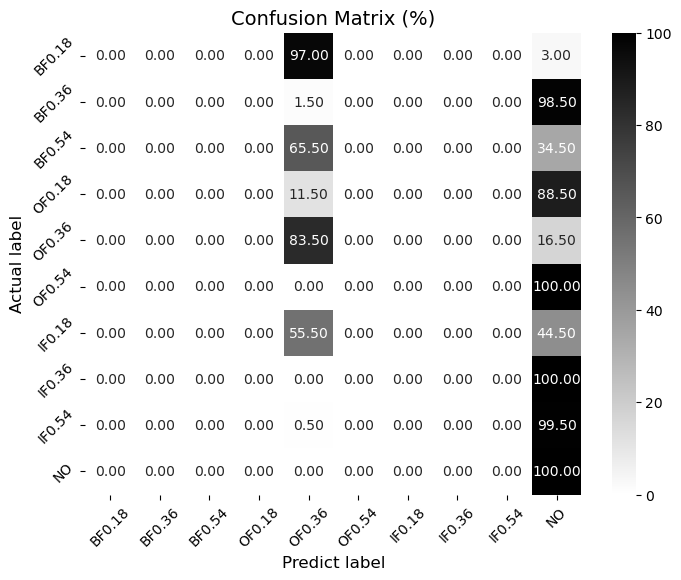

In [ ]:
# 클래스 라벨 정의
labels = ["BF0.18", "BF0.36", "BF0.54", "OF0.18", "OF0.36", "OF0.54", "IF0.18", "IF0.36", "IF0.54", "NO"]

plt.figure(figsize=(8, 6))

# 히트맵 그리기
sns.heatmap(cm_percentage, annot=True, fmt=".2f", cmap="gray_r",
            xticklabels=labels, yticklabels=labels, cbar=True)

# 축 레이블 추가
plt.xlabel("Predict label", fontsize=12)
plt.ylabel("Actual label", fontsize=12)

# 회전된 라벨 스타일 적용
plt.xticks(rotation=45)
plt.yticks(rotation=45)

# 그래프 표시
plt.title("Confusion Matrix (%)", fontsize=14)
plt.show()
